## Prequisites Notebook

For the code in this notebook to work properly, the code below imports `numpy` and `matplotlib`. 

In [4]:
import handcalcs.render
import numpy as np
import matplotlib.pyplot as plt

Throughout this notebook, the numerical integration scheme for all SIR models is the 4th order Runge–Kutta (RK4), which is implemented as described by [1] below.

In [8]:
def RK4(f, current_state: tuple, step_size: float = 0.01) -> float:
    k1 = step_size * f(*current_state)

    k2 = step_size * f(
        *[current_state[i] + k1 * 0.5 for i in range(len(current_state))]
    )
    k3 = step_size * f(
        *[current_state[i] + k2 * 0.5 for i in range(len(current_state))]
    )
    k4 = step_size * f(*[current_state[i] + k3 for i in range(len(current_state))])

    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

## 1.1 Implementation of The Naive SIR Model
The following code defines the differential equations described per Keeling et al. [2] for the SIR model as `baseSIR` class. Although variants of the naive SIR model are introduced later on, all extensions of the SIR models make use of the `baseSIR` class.



### Initial States for $S$, $I$, $R$
The initial states for $S$ and $R$ are derived using the initial proportions of infectands, `I0`. For the Naive SIR model, the following assumptions are made:
1. The population is known to stay constant over time, $S + I + R = 1$
2. There is no initial immunity, $R(0) = 0$.

Therefore, the initial states may be defined as follows:
1. $S(0) = 1-I(0)$
2. $R(0) = 0$

### Differential Equations for State Transitions
The differential equations that govern the transition from one state to another are implemented straightforwardly as functions `dSdt()`, `dIdt()` in `baseSIR`. Per Keeling et al. [2], for the frequency dependent formulation, are given by
$$
\frac{dS}{dt} = -\beta S I \\
\frac{dI}{dt} = \beta S I - \gamma I \\
\frac{dR}{dt} = \gamma I
$$
Due to the assumptions of the Naive SIR model, $\frac{dR}{dt}$ does not have to be implemented in `baseSIR`, as $S + I + R = 1$ has to hold, and therefore $R$ can be found after using the updated states of $S$ and $I$.

### Finding values for $S$, $I$, $R$ at time $t$
To find the updated values of $S$ and $I$, the 4th order Runge–Kutta (RK4) scheme is used to numerically integrate the differential equations $\frac{dS}{dt}$ and $\frac{dI}{dt}$ in `numerical_integration()`. Given the current implementation of RK4 is quick, a default step size of 0.01 is picked for accuracy. `numerical_integration()` provides an array containing the values of S, I and R over time for each step in RK4. 


In [14]:
class baseSIR:
    def __init__(self, beta: float, gamma: float, I0: float):
        """
        Initialize base SIR model with model parameters and initial conditions
        """
        self.beta = beta
        self.gamma = gamma

        self.S = 1 - I0
        self.I = I0
        self.R = 0

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I

    def dIdt(self, S, I) -> float:
        """
        Differential equation for infected population.
        """
        return self.beta * S * I - self.gamma * I

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method.
        """
        self.S += RK4(self.dSdt, (self.S, self.I), step_size=dt)
        self.I += RK4(self.dIdt, (self.S, self.I), step_size=dt)
        self.R = 1 - self.S - self.I

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.arange(0, t + dt, dt)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, I_values, R_values))

To verify that `baseSIR` works accordingly, the Naive SIR model is initialized with $\beta = 3$, $\gamma = 1$ and $I(0) = 0.01$ for 10 days. To observe a peak in infectands, $\frac{dI}{dt}$ should be equal to 0, which is the case when $S$ is equal to $\frac{1}{3}$ 
$$
\frac{dI}{dt} = \beta S I - \gamma I = 0 \\
           0  =  3SI - I \\  
           0  =  I(3S - 1) \\
           0  = 3S - 1 \\
           S = \frac{1}{3}
$$
`matplotlib` is used to plot curves for $S$, $I$ and $R$ seen in the graph below. It appears that `baseSIR` works as expected.

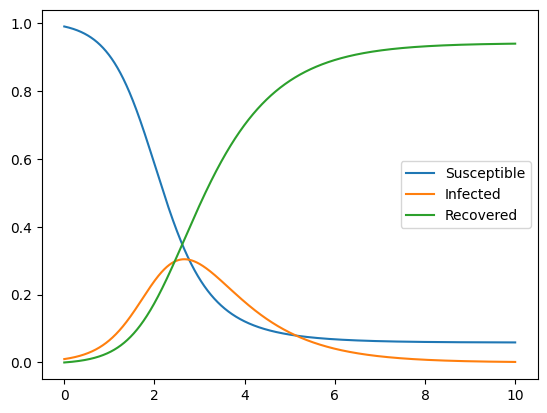

In [75]:
sir_model = baseSIR(beta=3, gamma=1, I0=0.01)
data = sir_model.numerical_integration(t=10, dt=0.001)

plt.plot(data[:, 0], data[:, 1], label="Susceptible")
plt.plot(data[:, 0], data[:, 2], label="Infected")
plt.plot(data[:, 0], data[:, 3], label="Recovered")
# plt.axhline(y=1/3, color='tab:red', linestyle='--', label='S = 1/3')
plt.legend()
plt.show()

### Observing Epidemics

In general, infectious diseases turn into epidemics when a peak in infectands is observed over time. Mathematically, this implies that, for the naive SIR model, that
1. Before the peak, the number of infectands rose, $\frac{dI}{dt} > 0$
2. Peaked, meaning that the number of infectands has attained its maximum, $\frac{dI}{dt} = 0$.
3. After the peak, the number of infectands decreased, $\frac{dI}{dt} < 0$

Rewriting the differential equation $\frac{dI}{dt}$ by factoring out $\gamma$ results in: 
$$
\frac{dI}{dt} = I(\beta S - \gamma) = I\gamma(\frac{\beta}{\gamma} - 1)
$$
The above equation reveals that $\frac{dI}{dt}$ can only be 0 when:
* $(\frac{\beta}{\gamma} - 1)$ is equal to 0, which can only occur when $\frac{\beta}{\gamma} = 1 $
* $I\gamma$ is equal to 0, which can only occur when $I$ is 0 as $\gamma$ is defined to be larger than 0.

Therefore, in the code below, two grids of $\beta$ and $\gamma$ are defined. `epidemic_combinations` contains combinations of $\beta$ and $\gamma$ where $\frac{\beta}{\gamma} > 1$, `extinction_combinations` contains combinations of $\beta$ and $\gamma$ where $\frac{\beta}{\gamma} < 1$


In [77]:
beta_values = np.linspace(0.25, 1, 5)
gamma_values = np.linspace(0.25, 1, 5)

epidemic_combinations = [
    (beta, gamma) for beta in beta_values for gamma in gamma_values if beta / gamma > 1
]

extinction_combinations = [
    (beta, gamma) for beta in beta_values for gamma in gamma_values if beta / gamma < 1
]


Phase diagrams are plotted using `phase_diagram()` defined below. To create lines for each initial state of $I$, the SIR model is fitted for each value in the `I0_values` array.

In [78]:
def phase_diagram(
    SIR,
    beta,
    gamma,
    I0_values,
    t=300,
    dt=0.01,
    title=None,
    subplot_index=None,
    **kwargs,
):
    if subplot_index is not None:
        plt.subplot(2, 3, subplot_index)  # 2 rows, 3 columns

    plt.plot([1, 0], [0, 1], "r-", linewidth=1, alpha=0.7, label="Diagonal")

    for I0 in I0_values:
        model_instance = SIR(beta=beta, gamma=gamma, I0=I0, **kwargs)
        data = model_instance.numerical_integration(t=t, dt=dt)
        plt.plot(data[:, 1], data[:, 2], color="lightblue", linewidth=1.5, alpha=0.7)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("Susceptible (S)")
    plt.ylabel("Infected (I)")
    plt.title(title, fontsize=10)
    plt.grid(True, color="gray", linestyle="--", linewidth=0.5)
    plt.gca().set_facecolor("whitesmoke")

The above plot is created for different combinations of $\beta$ and $\gamma$ which have either been categorized as possible epidemic and extinction parameter values for the SIR model. Finally, all (sub)plots are placed into a single plot.  

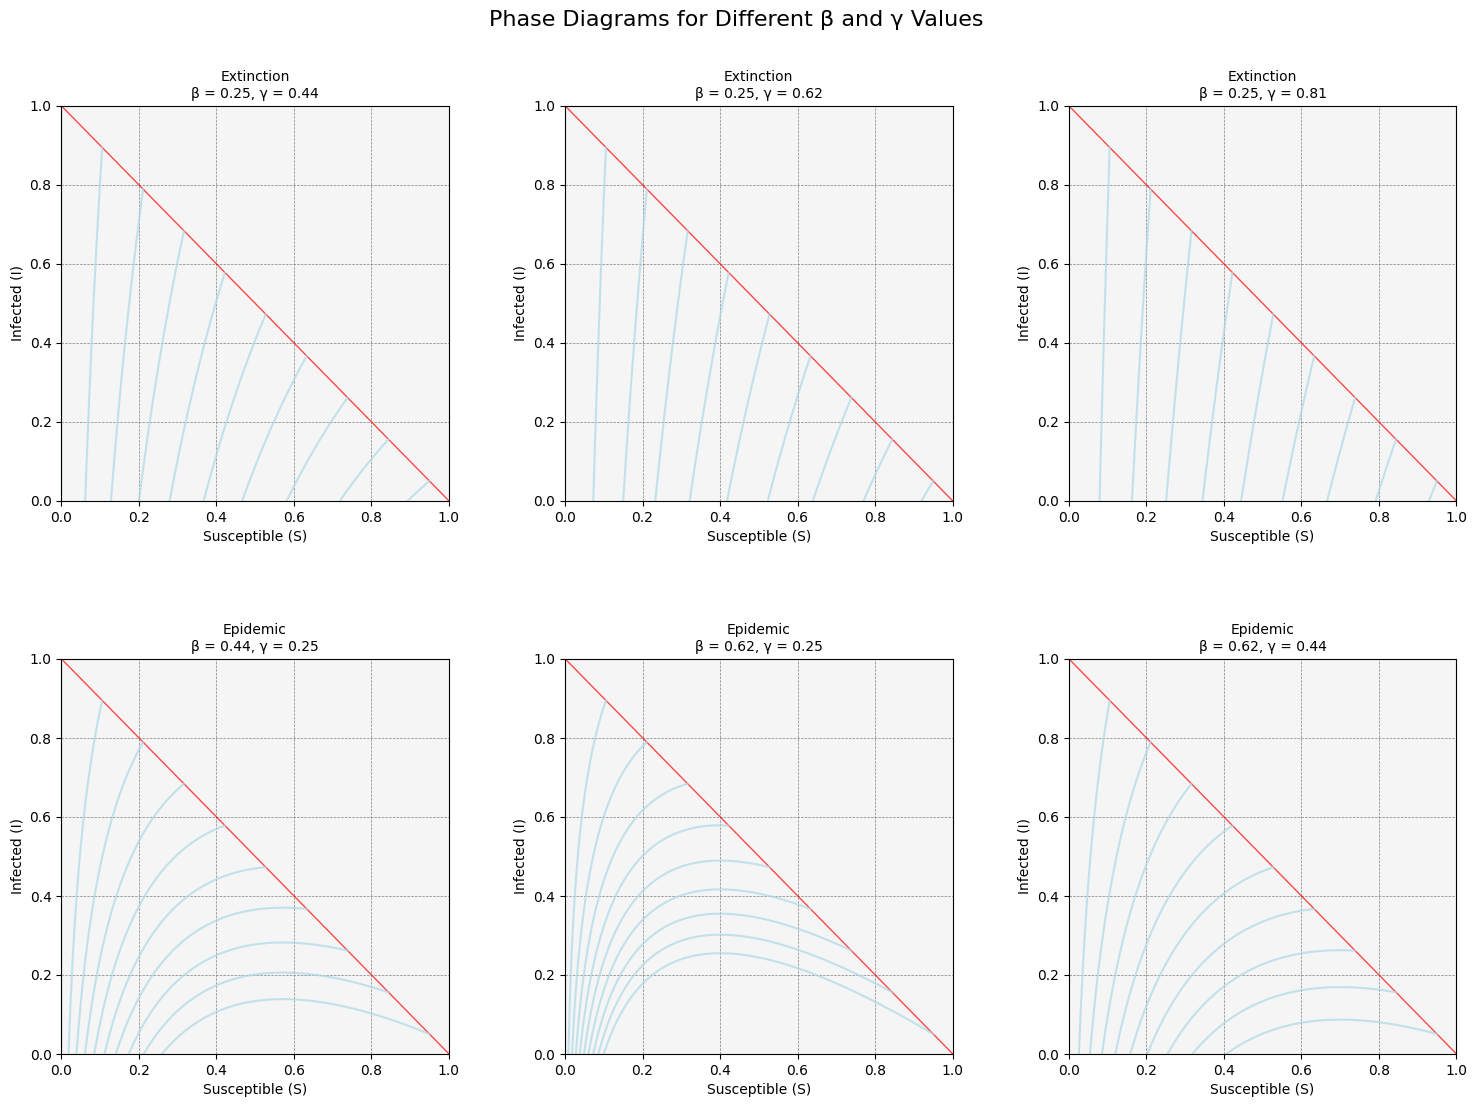

In [79]:
I0_values = np.linspace(0.05, 1, 10)

plt.figure(figsize=(18, 12))

for i, (beta, gamma) in enumerate(extinction_combinations[:3]):
    phase_diagram(
        baseSIR,
        beta,
        gamma,
        I0_values,
        t=300,
        dt=0.01,
        title=f"Extinction\nβ = {beta:.2f}, γ = {gamma:.2f}",
        subplot_index=i + 1,
    )

for i, (beta, gamma) in enumerate(epidemic_combinations[:3]):
    phase_diagram(
        baseSIR,
        beta,
        gamma,
        I0_values,
        t=300,
        dt=0.01,
        title=f"Epidemic\nβ = {beta:.2f}, γ = {gamma:.2f}",
        subplot_index=i + 4,
    )


plt.suptitle("Phase Diagrams for Different β and γ Values", fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.show()

The following conclusion are observed from the phase plots above:

* When $\frac{\beta}{\gamma} > 1$, for all possible initial states for $I(0)$ flow to 0 without attaining a peak over time. 
* When $\frac{\beta}{\gamma} < 1$, although some extreme initial states for $I(0)$ flow to 0 without increasing, for more reasonable states for $I(0)$, an intermediate peak is observed.

Therefore, whether $\frac{\beta}{\gamma}$ is above or below 1 seems to determine whether an infectious disease becomes an epidemic. This fraction is also known as the basic reproductive number, which is defined as how many secondary infections results from a single (primary) infection. 

## 1.2 Fitting the SIR model

To fit the Naive SIR model to the Influenza outbreak situation, a custom optimizer is created for `baseSIR` and their variants.


 `solverSIR` takes a loss function, `loss_fn()`, and optimizes a set of parameters to fit to an array of the observed proportion of infectands, `obsS`. In order for solverSIR to work for any variant of `baseSIR`, a distinction is made between the SIR parameters to optimize, `init_params` and `params`, and SIR parameters to hold constant, `**kwargs`.


To compute the gradient, $\nabla$, the forward finite difference method described by [1] is used. Firstly, the value of the loss function,  $\mathcal{L}$, is calculated for the SIR model associated with a set of parameters. Then, $\mathcal{L}$, is found for a small, finite increase, $\epsilon$. Finally, both values are subtracted from each other and divided by $\epsilon$. For the `baseSIR` model, the gradient is defined as follows:
$$

\nabla = \begin{bmatrix} \frac{\mathcal{L}(\beta + \epsilon, \gamma) - \mathcal{L}(\beta, \gamma)}{\epsilon} \\
\frac{\mathcal{L}(\beta, \gamma + \epsilon) - \mathcal{L}(\beta, \gamma)}{\epsilon} \end{bmatrix}
$$
To update the values of each parameter using the gradient, a variant of gradient descent, AdaGrad, is implemented. AdaGrad allows for an adaptive learning rate for each parameter.

In [82]:
class solverSIR:
    def __init__(self, SIR, loss_fn, init_params, **kwargs):
        self.classSIR = SIR
        self.loss_fn = loss_fn
        self.params = np.array(init_params)
        self.kwargs = kwargs

    def computeLoss(self, params, obsS):
        time = len(obsS)

        model_t = self.classSIR(*params, **self.kwargs).numerical_integration(time - 1)

        fitS_t = model_t[np.isin(model_t[:, 0], np.arange(0, time + 1)), 2]

        loss_t = self.loss_fn(obsS, fitS_t)

        return loss_t

    def computeGrad(self, obsS, params, epsilon=1e-6):
        grad = np.zeros_like(params)

        loss_t = self.computeLoss(params, obsS)

        for i, _ in enumerate(params):
            params[i] += epsilon

            loss_dt = self.computeLoss(params, obsS)

            grad[i] = (loss_dt - loss_t) / epsilon

            params[i] -= epsilon  # Restore the original parameter

        return grad

    def optimize(self, obsS, learning_rate=0.01, max_iterations=1000, epsilon=1e-8):
        params = np.array(self.params, dtype=float)

        lowest_loss = float("inf")
        best_params = params.copy()

        # Implement Adagrad
        accumulated_grad_squares = np.zeros_like(params)

        for iteration in range(max_iterations):
            grad = self.computeGrad(obsS, params)

            params -= learning_rate * grad

            accumulated_grad_squares += grad**2

            adjusted_grad = grad / (np.sqrt(accumulated_grad_squares) + epsilon)
            params -= learning_rate * adjusted_grad

            current_loss = self.computeLoss(params, obsS)

            prev_loss = current_loss

            if current_loss < lowest_loss:
                lowest_loss = current_loss
                best_params = params.copy()

            if iteration % 100 == 0:
                print(
                    f"Iteration {iteration}: Lowest Loss = {lowest_loss}, Best Parameters = {best_params}"
                )

        self.params = best_params
        return best_params, lowest_loss

We define the Mean Squared Error as the loss function to be optimized for the SIR model below.

In [86]:
def MSE(estimated_data, observed_data):
    return np.mean((observed_data - estimated_data) ** 2)

Below, the `baseSIR` model is fitted for the Influenza data. The initial values for $\beta$ and $\gamma$ are chosen arbitrary. A high initial learning rate was chosen in order to converge quickly towards the minimum value of the loss function.

In [134]:
school_data = (
    np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5]) / 763
)
solver = solverSIR(baseSIR, MSE, [1, 1], I0=school_data[0])
best_params, loss_value = solver.optimize(
    school_data, learning_rate=0.10, max_iterations=1000
)


Iteration 0: Lowest Loss = 0.03497408094350232, Best Parameters = [1.10023504 0.89976225]
Iteration 100: Lowest Loss = 0.0004634647219304517, Best Parameters = [1.66523337 0.44993755]
Iteration 200: Lowest Loss = 0.0004634647218901702, Best Parameters = [1.66523363 0.44993764]
Iteration 300: Lowest Loss = 0.00046346472189016843, Best Parameters = [1.66523363 0.44993764]
Iteration 400: Lowest Loss = 0.00046346472189016756, Best Parameters = [1.66523363 0.44993764]
Iteration 500: Lowest Loss = 0.00046346472189016756, Best Parameters = [1.66523363 0.44993764]
Iteration 600: Lowest Loss = 0.00046346472189016713, Best Parameters = [1.66523363 0.44993764]
Iteration 700: Lowest Loss = 0.00046346472189016713, Best Parameters = [1.66523363 0.44993764]
Iteration 800: Lowest Loss = 0.0004634647218901669, Best Parameters = [1.66523363 0.44993764]
Iteration 900: Lowest Loss = 0.0004634647218901669, Best Parameters = [1.66523363 0.44993764]


The best parameters are fitted again and plotted against the observed Infectand proportion data. 

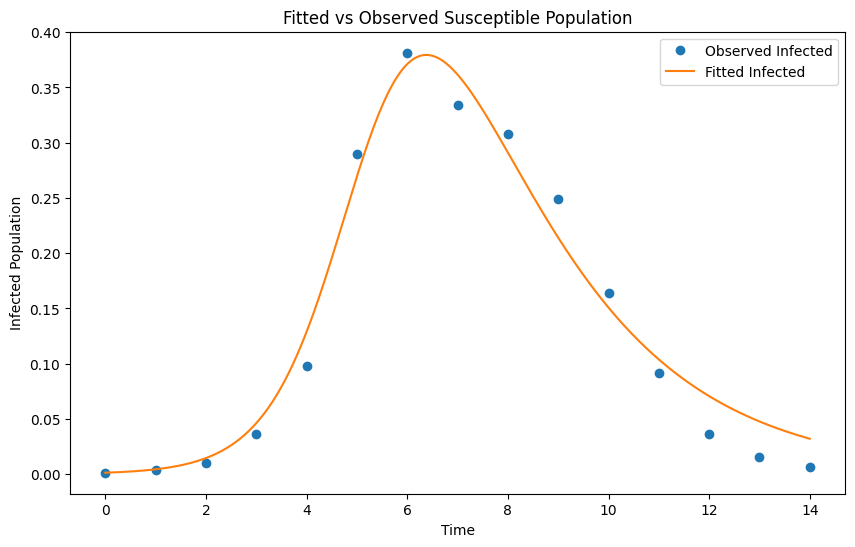

In [136]:
time_school = len(school_data)

best_model = baseSIR(*best_params, school_data[0])
best_data = best_model.numerical_integration(time_school - 1)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, time_school), school_data, "o", label="Observed Infected")
plt.plot(best_data[:, 0], best_data[:, 2], "-", label="Fitted Infected")
plt.xlabel("Time")
plt.ylabel("Infected Population")
plt.title("Fitted vs Observed Susceptible Population")
plt.legend()
plt.show()

## 1.3 Vaccination Strategies

The following two possible vaccination strategies for the Influenza school outbreak case are explored:
* A arbitrary flat vaccination rate kicking in at day 0
* "Flatten the Curve"-strategy using dynamic intervention based on arbitrary hospital capacity

### Flat vaccination rate
Pupils could be vaccinated from day 0 with a flat vaccination rate. In that case, $\frac{dS}{dt}$ needs to be redefined as follows:
$$
\frac{dS}{dt}  = \beta S I - \alpha S
$$
The vaccination rate, $\alpha$, is equal to the proportion of susceptible individuals who are vaccinated at each state. To implement the vaccination rate, a new class, `flatVaccinationSIR`, that inherits from `baseSIR` is defined. The only adjustment is the inclusion of $\alpha$, the vaccination rate, and the re-defined differential equation for $\frac{dS}{dt}$. 

In [119]:
class flatVaccinationSIR(baseSIR):
    def __init__(self, beta: float, gamma: float, I0: float, vaccination_rate: float):
        """
        Initialize SIR model with vaccination parameters
        """
        super().__init__(beta, gamma, I0)
        self.vaccination_rate = vaccination_rate

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I - self.vaccination_rate * S

An arbitrary value for the vaccination rate is picked. In this case, $\alpha$ is set to $0.05$. 

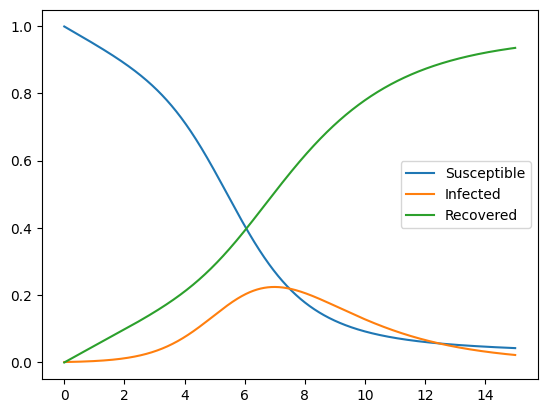

Reduction of peak: -40.84040559530769


In [148]:
basevax_model = flatVaccinationSIR(
    *best_params, I0=school_data[0], vaccination_rate=0.05
)
basevax_data = basevax_model.numerical_integration(t=time_school, dt=0.01)
plt.plot(basevax_data[:, 0], basevax_data[:, 1], label="Susceptible")
plt.plot(basevax_data[:, 0], basevax_data[:, 2], label="Infected")
plt.plot(basevax_data[:, 0], basevax_data[:, 3], label="Recovered")
plt.legend()
plt.show()

percentage_reduction = (
    (max(basevax_data[:, 2]) - max(best_data[:, 2])) / max(best_data[:, 2]) * 100
)

print(f"Reduction of peak: {percentage_reduction}")

The flat vaccination rate reduces the maximum attained proportion of infectands by approximately $41\%$. Therefore, such a strategy could be valid. However, it is improbable that vaccination can start from day 0. 

### "Flatten The Curve" with Dynamic Intervention

Another vaccination strategy could be to vaccination based on capacity. When the proportion of infectands get close to the capacity for the population, more pupils are vaccinated. However, the rate of vaccination also depends on the maximum number of vaccinations possible, assuming a limited propotion of Suspectible individuals can be vaccinated at a time.  A factor between 0 and 1, $\nu$, which modifies the vaccination rate. 
* When $\nu$ is equal to 0, the strongest intervention is applied
* When $\nu$ is equal to 1, no intervention is applied

$\nu$ is defined by the following logistic equation
$$
\phi = \frac{1}{1+e^{-l(I - C)}} \\
\nu_r = \phi\nu_{m}
$$

In [195]:
class ftcSIR(baseSIR):
    def __init__(self, beta: float, gamma: float, I0: float, vaccination_max: float, capacity: float, leniency: float):
        """
        Initialize SIR model with vaccination parameters
        """
        super().__init__(beta, gamma, I0)
        self.vaccination_max = vaccination_max
        self.capacity = capacity
        self.leniency = leniency

    def intervention_strength(self):
        return  1 / (1 + np.exp(-self.leniency * (self.I - self.capacity)))
    
    def vaccination_rate(self):
        return self.vaccination_max * (self.intervention_strength())
                    
    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I - self.vaccination_rate() * S 

    def numerical_integration(self, t: int, dt: float = 0.01):
        times = np.arange(0, t + dt, dt)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        vaccination_rates = [self.vaccination_rate()]
        intervention_strengths = [self.intervention_strength()]  # Store intervention strengths

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)

            vaccination_rates.append(self.vaccination_rate())  # Store vaccination rate
            intervention_strengths.append(self.intervention_strength())  # Store intervention strength

        return np.column_stack((times, S_values, I_values, R_values, vaccination_rates, intervention_strengths))

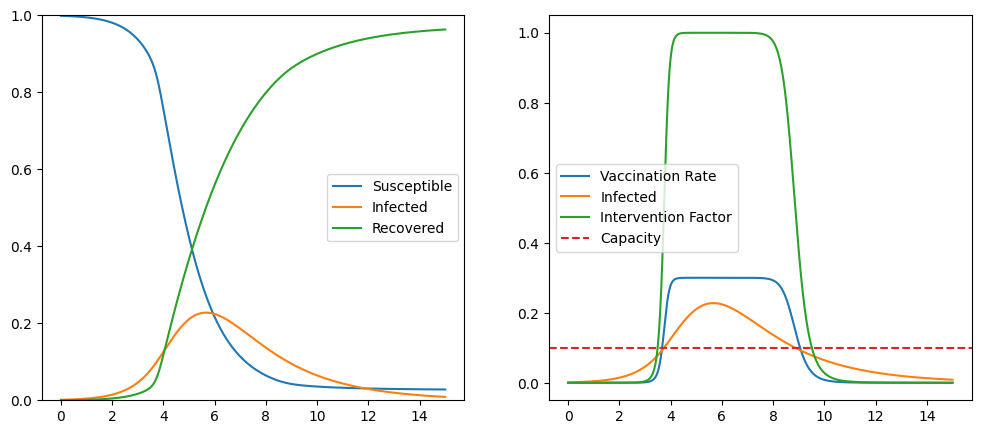

In [222]:
ftcvax_model = ftcSIR(
    *best_params, I0=school_data[0], vaccination_max=0.30, capacity=0.10, leniency=100
)

ftcvax_data = ftcvax_model.numerical_integration(t=time_school, dt=0.01)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) 
plt.plot(ftcvax_data[:, 0], ftcvax_data[:, 1], label="Susceptible")
plt.plot(ftcvax_data[:, 0], ftcvax_data[:, 2], label="Infected")
plt.plot(ftcvax_data[:, 0], ftcvax_data[:, 3], label="Recovered")
plt.ylim(0, 1)
plt.legend()


plt.subplot(1, 2, 2)  
plt.plot(ftcvax_data[:, 0], ftcvax_data[:, 4], label="Vaccination Rate")
plt.plot(ftcvax_data[:, 0], ftcvax_data[:, 2], label="Infected")
plt.plot(ftcvax_data[:, 0], ftcvax_data[:, 5], label="Intervention Factor")
plt.axhline(y=0.10, color='tab:red', linestyle='--', label='Capacity')
plt.legend()

plt.show()